In [0]:
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
import random as rand
import tensorflow as tf
#import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 

In [0]:
content_path = 'venice-boat.jpg'
style_path = 'art-auction.jpg'

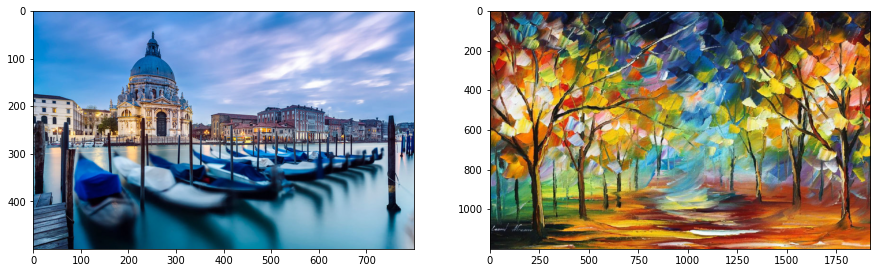

In [22]:
content_image = plt.imread(content_path)
style_image = plt.imread(style_path)

# For displaying images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.imshow(content_image)
ax2.imshow(style_image)
plt.show()

In [0]:
CONTENT_LAYERS = ['block5_conv2']
STYLE_LAYERS = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [0]:
def load_and_preprocess_image(width, height, image_path):
    img = Image.open(image_path)
    
    img = img.resize((width, height), Image.ANTIALIAS)
       
    img = np.array(img)
    img = np.expand_dims(img, axis=0)

    img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return img

In [0]:
def depreprocess_img(img):
    image = img.copy()
    if len(image.shape) == 4:
      #Remove extra batch dimension
        image = np.squeeze(image, 0)        
    
    #Remove zero-center by mean pixel
    image[:, :, 0] += 103.939
    image[:, :, 1] += 116.779
    image[:, :, 2] += 123.68
    # Flip the channels from BGR to RGB
    image = image[:, :, ::-1]

    image = np.clip(image, 0, 255).astype('uint8')
    return image

In [0]:
def save_generated_image(image, file_name):
  Image.fromarray(image).save(file_name)

In [0]:
def build_model(style_layers, content_layers, pooling_value):    
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', pooling = pooling_value)
    vgg.trainable = False
    
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
   
    return models.Model(vgg.input, model_outputs)

In [0]:
def content_loss_fun(content_feature, output_content_feature):
    return tf.keras.backend.sum(tf.square(output_content_feature - content_feature))

In [0]:
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    
    return gram / tf.cast(n, tf.float32)

In [0]:
def style_loss_fun(style_feature, output_style_feature):    
    style_gram = gram_matrix(style_feature)    
    output_style_gram = gram_matrix(output_style_feature)
    
    return tf.keras.backend.sum(tf.square(style_gram - output_style_gram))

In [0]:
def get_feature_representations(model, content_path, style_path, num_style_layers, width, height):  
   
    content_image = load_and_preprocess_image(width, height, content_path)
    style_image = load_and_preprocess_image(width, height, style_path)    
    
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    
    return style_features, content_features

In [0]:
def compute_loss(model, init_image, style_features, content_features, alpha, beta):

  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:len(style_features)]
  content_output_features = model_outputs[len(style_features):]
  
  style_loss = 0
  content_loss = 0
  
  for style_feature, output_style_feature in zip(style_features, style_output_features):
      style_loss += style_loss_fun(style_feature, output_style_feature[0]) / len(style_features)
  
  for content_feature, output_content_feature in zip(content_features, content_output_features):
      content_loss += content_loss_fun(content_feature, output_content_feature[0]) / len(content_features)
  
  style_loss *= beta    # beta represents style weight
  content_loss *= alpha  # alfa represents content weight
  
  loss = style_loss + content_loss 
 
  return loss

In [0]:
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        loss = compute_loss(**cfg)    
    
    return tape.gradient(loss, cfg['init_image']), loss

In [0]:
class Optimizator():
  def __init__(self, content_path, 
                       style_path,
                       style_layers,
                       content_layers,        
                       print_iterations,
                       alpha, 
                       beta,
                       epsilon,
                       pooling,
                       learning_rate,
                       iterations):
    self.content_path = content_path
    self.style_path = style_path
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.print_iterations = print_iterations
    self.alpha = alpha
    self.beta = beta
    self.epsilon = epsilon
    self.pooling = pooling
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.model = None
    
  def optimize(self): 
      #Make model for our neural style transfer
      self.model = build_model(self.style_layers, self.content_layers, self.pooling)    

      #Get feature maps for content and style images
      style_features, content_features = get_feature_representations(self.model, self.content_path, self.style_path, len(self.style_layers), 512, 512)
      
      #Load and preprocess initial output equalling content
      init_image = load_and_preprocess_image(512, 512, self.content_path)
      init_image = tf.Variable(init_image, dtype=tf.float32)
      
      #Define Adam optimizer
      adam = tf.optimizers.Adam(learning_rate=self.learning_rate, epsilon=self.epsilon)   
      
      best_loss, best_img = float('inf'), None   
      
      cfg = {
        'model': self.model,
        'alpha': self.alpha,
        'beta' : self.beta,
        'init_image': init_image,
        'style_features': style_features,
        'content_features': content_features
      }   
      
      global_start = time.time()    
      
      norm_means = np.array([103.939, 116.779, 123.68])
      min_vals = -norm_means
      max_vals = 255 - norm_means

      imgs = []
      for i in range(self.iterations):
          
          #Compute the gradients and the loss
          grads, loss = compute_grads(cfg)
          
          #Backpropagate to get optimal loss
          adam.apply_gradients([(grads, init_image)])
          
          #The values of the generated images can vary from -infinity to infinity so we clip them
          #as per the values subtracted during preprocessing
          clipped = tf.clip_by_value(init_image, min_vals, max_vals)
          init_image.assign(clipped)   
          
          #Compare if the new loss is smaller from the best loss
          if loss < best_loss:
            best_loss = loss
            best_img = init_image
          
          #Print current loss
          if i % self.print_iterations== 0:            
              print('Iteration: {}'.format(i))        
              print('Total loss: {:.6}'.format(loss))               
                  
              imgs.append(depreprocess_img(init_image.numpy()))
              
      print('Total time: {:.4f}s'.format(time.time() - global_start))
      print('Total best loss: {:.6}'.format(best_loss))     
      
      #Depreprocess best image and return it
      best_img = depreprocess_img(best_img.numpy())
      return best_img

In [0]:
config = {'content_path' : 'venice-boat.jpg', 
              'style_path' : 'art-auction.jpg',
              'style_layers': STYLE_LAYERS,
              'content_layers': CONTENT_LAYERS,             
              'iterations': 100,
              'print_iterations': 50,
              'alpha': 1e3,
              'beta': 1e-2,
              'epsilon': 1e-1, # A small constant for numerical stability.
              'pooling': 'avg',
              'learning_rate': 5}

In [36]:
optimizator = Optimizator(**config)
result_image = optimizator.optimize()

Iteration: 0
Total loss: 1.09379e+14
Iteration: 50
Total loss: 1.47624e+12
Total time: 781.2057s
Total best loss: 8.5619e+11


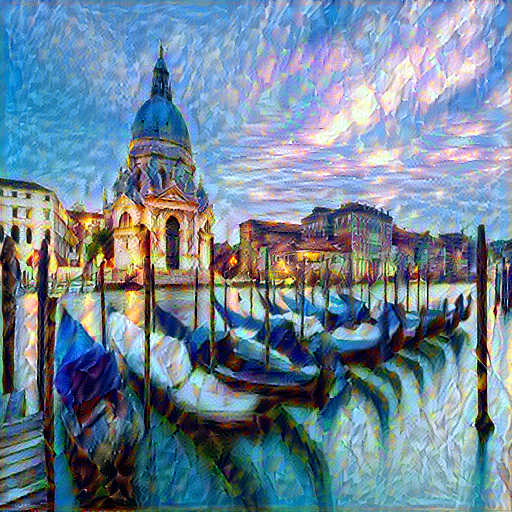

In [37]:
Image.fromarray(result_image)

In [0]:
save_generated_image(result_image, 'NewImage.jpg')